Data loading

In [2]:
import numpy as np
import os
import random
import tensorflow as tf
from scipy import misc
import imageio

def get_images(paths, labels, n_samples=None, shuffle=False):
    if n_samples is not None:
        sampler = lambda x: random.sample(x, n_samples)
    else:
        sampler = lambda x: x
    images_labels = [(i, os.path.join(path, image))
                     for i, path in zip(labels, paths)
                     for image in sampler(os.listdir(path))]
    #if shuffle:
        #random.shuffle(images_labels)
    return images_labels


def image_file_to_array(filename, dim_input):
    image = imageio.imread(filename)
    image = image.reshape([dim_input])
    image = image.astype(np.float32) / 255.0
    image = 1.0 - image
    return image


class DataGenerator(object):
    def __init__(self, num_classes, num_samples_per_class, num_meta_test_classes, num_meta_test_samples_per_class, config={}):
        self.num_samples_per_class = num_samples_per_class
        self.num_classes = num_classes
        self.num_meta_test_samples_per_class = num_meta_test_samples_per_class
        self.num_meta_test_classes = num_meta_test_classes
    
        data_folder = config.get('data_folder', './mask')
        self.img_size = config.get('img_size', (128, 128))
    
        self.dim_input = np.prod(self.img_size)
        self.dim_output = self.num_classes
    
        character_folders = [os.path.join(data_folder, family, character)
                             for family in os.listdir(data_folder)
                             if os.path.isdir(os.path.join(data_folder, family))
                             for character in os.listdir(os.path.join(data_folder, family))
                             if os.path.isdir(os.path.join(data_folder, family, character))]
    
        #random.seed(123)
        #random.shuffle(character_folders)
        #print(character_folders)
        num_val = 15
        num_train = 162
        self.metatrain_character_folders = character_folders[: num_train]
        self.metaval_character_folders = character_folders[num_train:num_train + num_val]
        self.metatest_character_folders = character_folders[num_train + num_val:]
        #print(self.metatrain_character_folders)

    def sample_batch(self, batch_type, batch_size, shuffle=False, swap=False):
        if batch_type == "meta_train":
            folders = self.metatrain_character_folders
            num_classes = self.num_classes
            num_samples_per_class = self.num_samples_per_class
        elif batch_type == "meta_val":
            folders = self.metaval_character_folders
            num_classes = self.num_classes
            num_samples_per_class = self.num_samples_per_class
        else:
            folders = self.metatest_character_folders
            num_classes = self.num_meta_test_classes
            num_samples_per_class = self.num_meta_test_samples_per_class
        all_image_batches, all_label_batches = [], []
        for i in range(batch_size):
            #sampled_character_folders = random.sample(folders, num_classes)
            labels_and_images = get_images(folders, range(num_classes), n_samples=num_samples_per_class, shuffle=False)
            labels = [li[0] for li in labels_and_images]
            images = [image_file_to_array(li[1], self.dim_input) for li in labels_and_images]
            images = np.stack(images)
            labels = np.array(labels).astype(np.int32)
            labels = np.reshape(labels, (num_classes, num_samples_per_class))
            labels = np.eye(num_classes, dtype=np.float32)[labels]
            images = np.reshape(images, (num_classes, num_samples_per_class, -1))
            
            batch = np.concatenate([labels, images], 2)
            
            #if shuffle:
                #for p in range(num_samples_per_class):
                    #np.random.shuffle(batch[:, p])
            labels = batch[:, :, :num_classes]
            images = batch[:, :, num_classes:]
            
            if swap:
                labels = np.swapaxes(labels, 0, 1)
                images = np.swapaxes(images, 0, 1)
            all_image_batches.append(images)
            all_label_batches.append(labels)
            
        all_image_batches = np.stack(all_image_batches)
        all_label_batches = np.stack(all_label_batches)
        return all_image_batches, all_label_batches

Dataset Check

training data
####################
meta-batch 0: 
####################


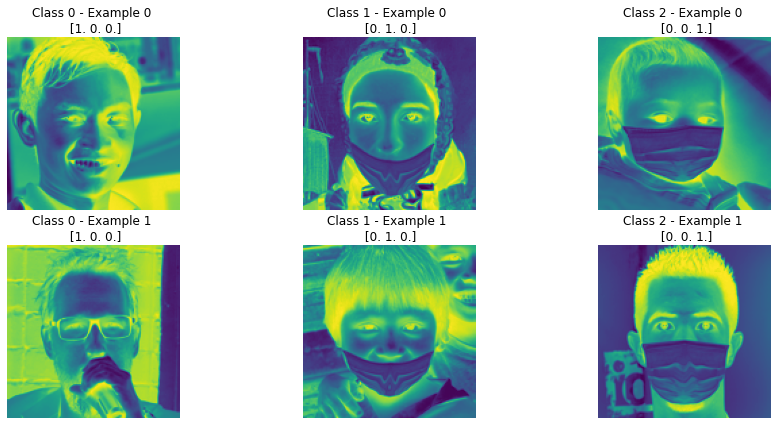

In [7]:
import matplotlib.pyplot as plt

n_way = 3
k_shot = 2
data_path = './mask'
meta_batch_size = 9

data_generator = DataGenerator(n_way, k_shot*2, n_way, k_shot*2, config={'data_folder': data_path})

all_image_batches, all_label_batches = data_generator.sample_batch(batch_type='meta_train', batch_size=meta_batch_size, shuffle=False, swap=False)

input_tr, input_ts = all_image_batches[:,:,:k_shot,:], all_image_batches[:,:,k_shot:,:]
label_tr, label_ts = all_label_batches[:,:,:k_shot,:], all_label_batches[:,:,k_shot:,:]

def visualize_sample_data(images, label):
    for b in range(len(images)): # batch size
        print("#"*20)
        print("meta-batch {}: ".format(b))
        print("#"*20)
        label
        count = 0
        fig = plt.figure(figsize=(15, 7))
        for sa in range(k_shot): # k-shot
            for cl in range(n_way): # n-way
                plt.subplot(k_shot, n_way, count + 1)
                plt.title("Class {} - Example {} \n {}".format(cl, sa, label[b, cl, sa]))
                image = images[b, cl, sa].reshape((128,128))
                plt.imshow(image)
                plt.axis('off');
                count += 1
        break # first meta batch sample visualization
        
        plt.show()

print("training data")        
images = input_tr
label = label_tr
visualize_sample_data(images, label)


testing data
####################
meta-batch 0: 
####################


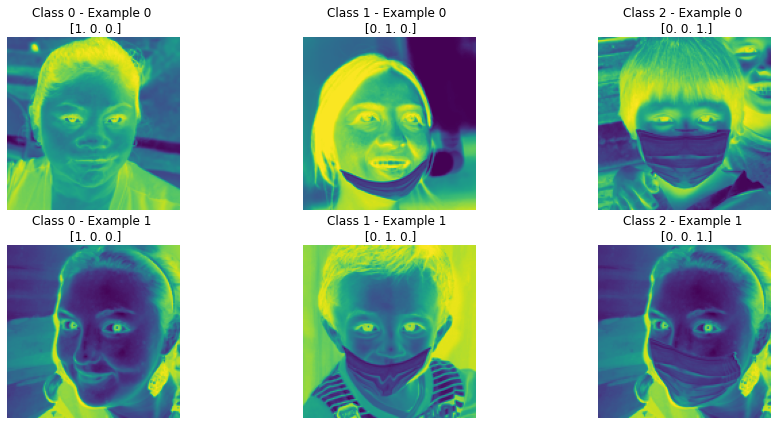

In [20]:
print("testing data")        
images = input_ts
label = label_ts
visualize_sample_data(images, label)

Utility functions

In [21]:
import numpy as np
import os
import random
import tensorflow as tf

## Loss utilities
def cross_entropy_loss(pred, label, k_shot):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=tf.stop_gradient(label)) / k_shot)

def accuracy(labels, predictions):
    return tf.reduce_mean(tf.cast(tf.equal(labels, predictions), dtype=tf.float32))

Convolutional layers used by MAML Model

In [23]:
seed = 123
def conv_block(inp, cweight, bweight, bn, activation=tf.nn.relu, residual=False):
    stride, no_stride = [1,2,2,1], [1,1,1,1]
  
    conv_output = tf.nn.conv2d(input=inp, filters=cweight, strides=no_stride, padding='SAME') + bweight
    normed = bn(conv_output)
    normed = activation(normed)
    return normed

class ConvLayers(tf.keras.layers.Layer):
    def __init__(self, channels, dim_hidden, dim_output, img_size):
        super(ConvLayers, self).__init__()
        self.channels = channels
        self.dim_hidden = dim_hidden
        self.dim_output = dim_output
        self.img_size = img_size
    
        weights = {}
    
        dtype = tf.float32
        weight_initializer =  tf.keras.initializers.GlorotUniform()
        k = 3
    
        weights['conv1'] = tf.Variable(weight_initializer(shape=[k, k, self.channels, self.dim_hidden]), name='conv1', dtype=dtype)
        weights['b1'] = tf.Variable(tf.zeros([self.dim_hidden]), name='b1')
        self.bn1 = tf.keras.layers.BatchNormalization(name='bn1')
        weights['conv2'] = tf.Variable(weight_initializer(shape=[k, k, self.dim_hidden, self.dim_hidden]), name='conv2', dtype=dtype)
        weights['b2'] = tf.Variable(tf.zeros([self.dim_hidden]), name='b2')
        self.bn2 = tf.keras.layers.BatchNormalization(name='bn2')
        weights['conv3'] = tf.Variable(weight_initializer(shape=[k, k, self.dim_hidden, self.dim_hidden]), name='conv3', dtype=dtype)
        weights['b3'] = tf.Variable(tf.zeros([self.dim_hidden]), name='b3')
        self.bn3 = tf.keras.layers.BatchNormalization(name='bn3')
        weights['conv4'] = tf.Variable(weight_initializer([k, k, self.dim_hidden, self.dim_hidden]), name='conv4', dtype=dtype)
        weights['b4'] = tf.Variable(tf.zeros([self.dim_hidden]), name='b4')
        self.bn4 = tf.keras.layers.BatchNormalization(name='bn4')
        weights['w5'] = tf.Variable(weight_initializer(shape=[self.dim_hidden, self.dim_output]), name='w5', dtype=dtype)
        weights['b5'] = tf.Variable(tf.zeros([self.dim_output]), name='b5')
        self.conv_weights = weights

    def call(self, inp, weights):
        channels = self.channels
        inp = tf.reshape(inp, [-1, self.img_size, self.img_size, channels])
        hidden1 = conv_block(inp, weights['conv1'], weights['b1'], self.bn1)
        hidden2 = conv_block(hidden1, weights['conv2'], weights['b2'], self.bn2)
        hidden3 = conv_block(hidden2, weights['conv3'], weights['b3'], self.bn3)
        hidden4 = conv_block(hidden3, weights['conv4'], weights['b4'], self.bn4)
        hidden4 = tf.reduce_mean(input_tensor=hidden4, axis=[1, 2])
        return tf.matmul(hidden4, weights['w5']) + weights['b5']

MAML model

In [25]:
"""MAML model code"""
import numpy as np
import sys
import tensorflow as tf
from functools import partial


class MAML(tf.keras.Model):
    def __init__(self, dim_input=1, dim_output=1, 
                 num_inner_updates=1,
                 inner_update_lr=0.4, num_filters=32, 
                 k_shot=5, learn_inner_update_lr=False):
        super(MAML, self).__init__()
        self.dim_input = dim_input
        self.dim_output = dim_output
        self.inner_update_lr = inner_update_lr
        self.loss_func = partial(cross_entropy_loss, k_shot=k_shot)
        self.dim_hidden = num_filters
        self.channels = 1
        self.img_size = int(np.sqrt(self.dim_input/self.channels))
    
        # outputs_ts[i] and losses_ts_post[i] are the output and loss after i+1 inner gradient updates
        losses_tr_pre, outputs_tr, losses_ts_post, outputs_ts = [], [], [], []
        accuracies_tr_pre, accuracies_ts = [], []
    
        # for each loop in the inner training loop
        outputs_ts = [[]]*num_inner_updates
        losses_ts_post = [[]]*num_inner_updates
        accuracies_ts = [[]]*num_inner_updates
    
        # Define the weights - these should NOT be directly modified by the
        # inner training loop
        tf.random.set_seed(seed)
        self.conv_layers = ConvLayers(self.channels, self.dim_hidden, self.dim_output, self.img_size)
    
        self.learn_inner_update_lr = learn_inner_update_lr
        if self.learn_inner_update_lr:
            self.inner_update_lr_dict = {}
            for key in self.conv_layers.conv_weights.keys():
                self.inner_update_lr_dict[key] = [tf.Variable(self.inner_update_lr, name='inner_update_lr_%s_%d' % (key, j)) for j in range(num_inner_updates)]
  
    #@tf.function
    def call(self, inp, meta_batch_size=25, num_inner_updates=1):
        def task_inner_loop(inp, reuse=True,
                      meta_batch_size=25, num_inner_updates=1):
            # the inner and outer loop data
            input_tr, input_ts, label_tr, label_ts = inp
            
            # weights corresponds to the initial weights in MAML (i.e. the meta-parameters)
            weights = self.conv_layers.conv_weights
            
            # the predicted outputs, loss values, and accuracy for the pre-update model (with the initial weights)
            # evaluated on the inner loop training data
            task_output_tr_pre, task_loss_tr_pre, task_accuracy_tr_pre = None, None, None
      
            # lists to keep track of outputs, losses, and accuracies of test data for each inner_update
            # where task_outputs_ts[i], task_losses_ts[i], task_accuracies_ts[i] are the output, loss, and accuracy
            # after i+1 inner gradient updates
            task_outputs_ts, task_losses_ts, task_accuracies_ts = [], [], []
        
            for i in range(num_inner_updates):
                with tf.GradientTape(persistent=True) as inner_tape:
                    # calcuating meta_train loss with training data [input_tr, label_tr]
                    task_output_tr_pre = self.conv_layers(inp=input_tr, weights=weights)
                    task_loss_tr_pre = self.loss_func(task_output_tr_pre, label_tr)
                    # end of with block
                    
                gradient=inner_tape.gradient(task_loss_tr_pre,weights)
                
                
                fast_weights={w_name:w-self.inner_update_lr*gradient[w_name] for w_name, w in weights.items()}

                task_outputs_ts.append(self.conv_layers(input_ts, fast_weights)) 
                task_losses_ts.append(self.loss_func(task_outputs_ts[-1], label_ts))

            task_accuracy_tr_pre = accuracy(tf.argmax(input=label_tr, axis=1), tf.argmax(input=tf.nn.softmax(task_output_tr_pre), axis=1))
            
            for j in range(num_inner_updates):
                task_accuracies_ts.append(accuracy(tf.argmax(input=label_ts, axis=1), tf.argmax(input=tf.nn.softmax(task_outputs_ts[j]), axis=1)))
                     
            task_output = [task_output_tr_pre, task_outputs_ts, task_loss_tr_pre, task_losses_ts, task_accuracy_tr_pre, task_accuracies_ts]
             
            return task_output

        input_tr, input_ts, label_tr, label_ts = inp
        
        unused = task_inner_loop((input_tr[0], input_ts[0], label_tr[0], label_ts[0]),
                                 False,
                                 meta_batch_size,
                                 num_inner_updates)
        out_dtype = [tf.float32, [tf.float32]*num_inner_updates, tf.float32, [tf.float32]*num_inner_updates]
        out_dtype.extend([tf.float32, [tf.float32]*num_inner_updates])
        
        task_inner_loop_partial = partial(task_inner_loop, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)
        
        result = tf.map_fn(task_inner_loop_partial,
                           elems=(input_tr, input_ts, label_tr, label_ts),
                           dtype=out_dtype,
                           parallel_iterations=meta_batch_size)    
        
        return result

In [26]:
import csv
import numpy as np
import pickle
import random
import tensorflow as tf

def outer_train_step(inp, model, optim, meta_batch_size=25, num_inner_updates=1):
    with tf.GradientTape(persistent=False) as outer_tape:
        result = model(inp, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)
    
        outputs_tr, outputs_ts, losses_tr_pre, losses_ts, accuracies_tr_pre, accuracies_ts = result
    
        total_losses_ts = [tf.reduce_mean(loss_ts) for loss_ts in losses_ts]

    gradients = outer_tape.gradient(total_losses_ts[-1], model.trainable_variables)
    optim.apply_gradients(zip(gradients, model.trainable_variables))
  
    total_loss_tr_pre = tf.reduce_mean(losses_tr_pre)
    total_accuracy_tr_pre = tf.reduce_mean(accuracies_tr_pre)
    total_accuracies_ts = [tf.reduce_mean(accuracy_ts) for accuracy_ts in accuracies_ts]

    return outputs_tr, outputs_ts, total_loss_tr_pre, total_losses_ts, total_accuracy_tr_pre, total_accuracies_ts

def outer_eval_step(inp, model, meta_batch_size=25, num_inner_updates=1):
    result = model(inp, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)
  
    outputs_tr, outputs_ts, losses_tr_pre, losses_ts, accuracies_tr_pre, accuracies_ts = result
  
    total_loss_tr_pre = tf.reduce_mean(losses_tr_pre)
    total_losses_ts = [tf.reduce_mean(loss_ts) for loss_ts in losses_ts]
  
    total_accuracy_tr_pre = tf.reduce_mean(accuracies_tr_pre)
    total_accuracies_ts = [tf.reduce_mean(accuracy_ts) for accuracy_ts in accuracies_ts]
  
    return outputs_tr, outputs_ts, total_loss_tr_pre, total_losses_ts, total_accuracy_tr_pre, total_accuracies_ts  


def meta_train_fn(model, exp_string, data_generator,
               n_way=5, meta_train_iterations=15000, meta_batch_size=25,
               log=True, logdir='./log/model', k_shot=1, num_inner_updates=1, meta_lr=0.001):
    SUMMARY_INTERVAL = 10
    SAVE_INTERVAL = 100
    PRINT_INTERVAL = 10  
    TEST_PRINT_INTERVAL = PRINT_INTERVAL*5
  
    pre_accuracies, post_accuracies = [], []
  
    num_classes = data_generator.num_classes
    img_size = data_generator.img_size
  
    optimizer = tf.keras.optimizers.Adam(learning_rate=meta_lr)

    for itr in range(meta_train_iterations):
    
        # sample a batch of training data and partition into
        # the support/training set (input_tr, label_tr) and the query/test set (input_ts, label_ts)
        # NOTE: The code assumes that the support and query sets have the same number of examples.
        
        all_image_batches, all_label_batches = data_generator.sample_batch(batch_type='meta_train', batch_size=meta_batch_size, shuffle=False, swap=False)
        
        input_tr, input_ts = all_image_batches[:,:,:k_shot,:], all_image_batches[:,:,k_shot:,:]
        label_tr, label_ts = all_label_batches[:,:,:k_shot,:], all_label_batches[:,:,k_shot:,:]
        
        # reshape input tensor
        input_tr = tf.reshape(input_tr, [-1, n_way*k_shot, img_size[0]*img_size[0]])
        input_ts = tf.reshape(input_ts, [-1, n_way*k_shot, img_size[0]*img_size[0]])
        label_tr = tf.reshape(label_tr, [-1, n_way*k_shot, n_way])
        label_ts = tf.reshape(label_ts, [-1, n_way*k_shot, n_way])
    
    
        inp = (input_tr, input_ts, label_tr, label_ts)
        
        result = outer_train_step(inp, model, optimizer, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)
    
        if itr % SUMMARY_INTERVAL == 0:
            pre_accuracies.append(result[-2])
            post_accuracies.append(result[-1][-1])
    
        if (itr!=0) and itr % PRINT_INTERVAL == 0:
            print_str = 'Iteration %d: pre-inner-loop train accuracy: %.5f, post-inner-loop test accuracy: %.5f' % (itr, np.mean(pre_accuracies), np.mean(post_accuracies))
            print(print_str)
            pre_accuracies, post_accuracies = [], []
    
        if (itr!=0) and itr % TEST_PRINT_INTERVAL == 0:
      
            # sample a batch of validation data and partition it into
            # the support/training set (input_tr, label_tr) and the query/test set (input_ts, label_ts)
            # NOTE: The code assumes that the support and query sets have the same number of examples.
        
            all_image_batches, all_label_batches = data_generator.sample_batch(batch_type='meta_val', batch_size=meta_batch_size, shuffle=False, swap=False)

            input_tr, input_ts = all_image_batches[:,:,:k_shot,:], all_image_batches[:,:,k_shot:,:]
            label_tr, label_ts = all_label_batches[:,:,:k_shot,:], all_label_batches[:,:,k_shot:,:]
            
            # reshape input tensor
            input_tr = tf.reshape(input_tr, [-1, n_way*k_shot, img_size[0]*img_size[0]])
            input_ts = tf.reshape(input_ts, [-1, n_way*k_shot, img_size[0]*img_size[0]])
            label_tr = tf.reshape(label_tr, [-1, n_way*k_shot, n_way])
            label_ts = tf.reshape(label_ts, [-1, n_way*k_shot, n_way])
    
      
            inp = (input_tr, input_ts, label_tr, label_ts)
            result = outer_eval_step(inp, model, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)
      
            print('Meta-validation pre-inner-loop train accuracy: %.5f, meta-validation post-inner-loop test accuracy: %.5f' % (result[-2], result[-1][-1]))

        
            model_file = logdir + '/' + exp_string +  '/model' + str(itr)
            print("Saving to ", model_file)
            model.save_weights(model_file)
    
    model_file = logdir + '/' + exp_string +  '/model' + str(itr)
    print("Saving to ", model_file)
    model.save_weights(model_file)

# calculated for omniglot
NUM_META_TEST_POINTS = 600

def meta_test_fn(model, data_generator, n_way=5, 
                 meta_batch_size=25, k_shot=1,
                 num_inner_updates=1):
  
    num_classes = data_generator.num_classes
    img_size = data_generator.img_size
  
    np.random.seed(1)
    random.seed(1)
  
    meta_test_accuracies = []
  
    for _ in range(NUM_META_TEST_POINTS):
    
        # sample a batch of test data and partition it into
        # the support/training set (input_tr, label_tr) and the query/test set (input_ts, label_ts)
        # NOTE: The code assumes that the support and query sets have the same number of examples.
        
        all_image_batches, all_label_batches = data_generator.sample_batch(batch_type='meta_test', batch_size=meta_batch_size, shuffle=False, swap=False)
        
        input_tr, input_ts = all_image_batches[:,:,:k_shot,:], all_image_batches[:,:,k_shot:,:]
        label_tr, label_ts = all_label_batches[:,:,:k_shot,:], all_label_batches[:,:,k_shot:,:]
        
        # reshape input tensor
        input_tr = tf.reshape(input_tr, [-1, n_way*k_shot, img_size[0]*img_size[0]])
        input_ts = tf.reshape(input_ts, [-1, n_way*k_shot, img_size[0]*img_size[0]])
        label_tr = tf.reshape(label_tr, [-1, n_way*k_shot, n_way])
        label_ts = tf.reshape(label_ts, [-1, n_way*k_shot, n_way])

        
        inp = (input_tr, input_ts, label_tr, label_ts)
        result = outer_eval_step(inp, model, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)
    
        meta_test_accuracies.append(result[-1][-1])

    meta_test_accuracies = np.array(meta_test_accuracies)
    means = np.mean(meta_test_accuracies)
    stds = np.std(meta_test_accuracies)
    ci95 = 1.96*stds/np.sqrt(NUM_META_TEST_POINTS)
  
    print('Mean meta-test accuracy/loss, stddev, and confidence intervals')
    print((means, stds, ci95))


def run_maml(n_way=5, k_shot=1, meta_batch_size=25, meta_lr=0.001,
             inner_update_lr=0.4, num_filters=32, num_inner_updates=1,
             learn_inner_update_lr=False,
             resume=False, resume_itr=0, log=True, logdir='./log/model',
             data_path='./mask',meta_train=True,
             meta_train_iterations=15000, meta_train_k_shot=-1,
             meta_train_inner_update_lr=-1):


    # call data_generator and get data with k_shot*2 samples per class
    data_generator = DataGenerator(n_way, k_shot*2, n_way, k_shot*2, config={'data_folder': data_path})
  
    # set up MAML model
    dim_output = data_generator.dim_output
    dim_input = data_generator.dim_input
    model = MAML(dim_input,
                dim_output,
                num_inner_updates=num_inner_updates,
                inner_update_lr=inner_update_lr,
                k_shot=k_shot,
                num_filters=num_filters,
                learn_inner_update_lr=learn_inner_update_lr)

    if meta_train_k_shot == -1:
        meta_train_k_shot = k_shot
    if meta_train_inner_update_lr == -1:
        meta_train_inner_update_lr = inner_update_lr

    exp_string = 'cls_'+str(n_way)+'.mbs_'+str(meta_batch_size) + '.k_shot_' + str(meta_train_k_shot) + '.inner_numstep_' + str(num_inner_updates) + '.inner_updatelr_' + str(meta_train_inner_update_lr) + '.learn_inner_update_lr_' + str(learn_inner_update_lr)

    if meta_train:
        meta_train_fn(model, exp_string, data_generator,
                      n_way, meta_train_iterations, meta_batch_size, log, logdir,
                      k_shot, num_inner_updates, meta_lr)
    else:
        meta_batch_size = 1
    
        model_file = tf.train.latest_checkpoint(logdir + '/' + exp_string)
        print("Restoring model weights from ", model_file)
        model.load_weights(model_file)
    
        meta_test_fn(model, data_generator, n_way, meta_batch_size, k_shot, num_inner_updates)
  

In [27]:
run_maml(n_way=3, k_shot=1, inner_update_lr=0.4, num_inner_updates=1, meta_train_iterations=5000, logdir='./log/model')

Iteration 10: pre-inner-loop train accuracy: 0.34000, post-inner-loop test accuracy: 0.34000
Iteration 20: pre-inner-loop train accuracy: 0.33333, post-inner-loop test accuracy: 0.38667
Iteration 30: pre-inner-loop train accuracy: 0.33333, post-inner-loop test accuracy: 0.44000
Iteration 40: pre-inner-loop train accuracy: 0.50667, post-inner-loop test accuracy: 0.38667
Iteration 50: pre-inner-loop train accuracy: 0.42667, post-inner-loop test accuracy: 0.44000
Meta-validation pre-inner-loop train accuracy: 0.34667, meta-validation post-inner-loop test accuracy: 0.40000
Saving to  ./log/model/cls_3.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model50
Iteration 60: pre-inner-loop train accuracy: 0.46667, post-inner-loop test accuracy: 0.48000
Iteration 70: pre-inner-loop train accuracy: 0.36000, post-inner-loop test accuracy: 0.37333
Iteration 80: pre-inner-loop train accuracy: 0.41333, post-inner-loop test accuracy: 0.38667
Iteration 90: pre-inner-loop 

Iteration 600: pre-inner-loop train accuracy: 0.33333, post-inner-loop test accuracy: 0.89333
Meta-validation pre-inner-loop train accuracy: 0.33333, meta-validation post-inner-loop test accuracy: 0.81333
Saving to  ./log/model/cls_3.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model600
Iteration 610: pre-inner-loop train accuracy: 0.33333, post-inner-loop test accuracy: 0.84000
Iteration 620: pre-inner-loop train accuracy: 0.54667, post-inner-loop test accuracy: 0.78667
Iteration 630: pre-inner-loop train accuracy: 0.64000, post-inner-loop test accuracy: 0.68000
Iteration 640: pre-inner-loop train accuracy: 0.45333, post-inner-loop test accuracy: 0.89333
Iteration 650: pre-inner-loop train accuracy: 0.37333, post-inner-loop test accuracy: 0.80000
Meta-validation pre-inner-loop train accuracy: 0.48000, meta-validation post-inner-loop test accuracy: 0.65333
Saving to  ./log/model/cls_3.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_updat

Iteration 1180: pre-inner-loop train accuracy: 0.90667, post-inner-loop test accuracy: 0.68000
Iteration 1190: pre-inner-loop train accuracy: 0.84000, post-inner-loop test accuracy: 0.78667
Iteration 1200: pre-inner-loop train accuracy: 0.97333, post-inner-loop test accuracy: 0.88000
Meta-validation pre-inner-loop train accuracy: 0.92000, meta-validation post-inner-loop test accuracy: 0.76000
Saving to  ./log/model/cls_3.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model1200
Iteration 1210: pre-inner-loop train accuracy: 0.90667, post-inner-loop test accuracy: 0.88000
Iteration 1220: pre-inner-loop train accuracy: 0.96000, post-inner-loop test accuracy: 0.94667
Iteration 1230: pre-inner-loop train accuracy: 0.90667, post-inner-loop test accuracy: 0.92000
Iteration 1240: pre-inner-loop train accuracy: 0.93333, post-inner-loop test accuracy: 0.92000
Iteration 1250: pre-inner-loop train accuracy: 0.92000, post-inner-loop test accuracy: 0.93333
Meta-valida

Iteration 1760: pre-inner-loop train accuracy: 0.46667, post-inner-loop test accuracy: 1.00000
Iteration 1770: pre-inner-loop train accuracy: 0.44000, post-inner-loop test accuracy: 0.98667
Iteration 1780: pre-inner-loop train accuracy: 0.45333, post-inner-loop test accuracy: 0.97333
Iteration 1790: pre-inner-loop train accuracy: 0.45333, post-inner-loop test accuracy: 1.00000
Iteration 1800: pre-inner-loop train accuracy: 0.38667, post-inner-loop test accuracy: 1.00000
Meta-validation pre-inner-loop train accuracy: 0.52000, meta-validation post-inner-loop test accuracy: 0.82667
Saving to  ./log/model/cls_3.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model1800
Iteration 1810: pre-inner-loop train accuracy: 0.40000, post-inner-loop test accuracy: 0.98667
Iteration 1820: pre-inner-loop train accuracy: 0.44000, post-inner-loop test accuracy: 1.00000
Iteration 1830: pre-inner-loop train accuracy: 0.52000, post-inner-loop test accuracy: 1.00000
Iteration 1

Meta-validation pre-inner-loop train accuracy: 0.73333, meta-validation post-inner-loop test accuracy: 0.90667
Saving to  ./log/model/cls_3.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model2350
Iteration 2360: pre-inner-loop train accuracy: 0.61333, post-inner-loop test accuracy: 0.98667
Iteration 2370: pre-inner-loop train accuracy: 0.56000, post-inner-loop test accuracy: 1.00000
Iteration 2380: pre-inner-loop train accuracy: 0.50667, post-inner-loop test accuracy: 1.00000
Iteration 2390: pre-inner-loop train accuracy: 0.38667, post-inner-loop test accuracy: 1.00000
Iteration 2400: pre-inner-loop train accuracy: 0.40000, post-inner-loop test accuracy: 1.00000
Meta-validation pre-inner-loop train accuracy: 0.46667, meta-validation post-inner-loop test accuracy: 0.89333
Saving to  ./log/model/cls_3.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model2400
Iteration 2410: pre-inner-loop train accuracy: 0.44000, post-inner-

Iteration 2940: pre-inner-loop train accuracy: 0.66667, post-inner-loop test accuracy: 1.00000
Iteration 2950: pre-inner-loop train accuracy: 0.36000, post-inner-loop test accuracy: 1.00000
Meta-validation pre-inner-loop train accuracy: 0.36000, meta-validation post-inner-loop test accuracy: 0.93333
Saving to  ./log/model/cls_3.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model2950
Iteration 2960: pre-inner-loop train accuracy: 0.33333, post-inner-loop test accuracy: 1.00000
Iteration 2970: pre-inner-loop train accuracy: 0.44000, post-inner-loop test accuracy: 1.00000
Iteration 2980: pre-inner-loop train accuracy: 0.80000, post-inner-loop test accuracy: 0.98667
Iteration 2990: pre-inner-loop train accuracy: 0.84000, post-inner-loop test accuracy: 1.00000
Iteration 3000: pre-inner-loop train accuracy: 0.85333, post-inner-loop test accuracy: 1.00000
Meta-validation pre-inner-loop train accuracy: 0.81333, meta-validation post-inner-loop test accuracy: 0.8

Iteration 3520: pre-inner-loop train accuracy: 0.72000, post-inner-loop test accuracy: 0.48000
Iteration 3530: pre-inner-loop train accuracy: 0.49333, post-inner-loop test accuracy: 0.48000
Iteration 3540: pre-inner-loop train accuracy: 0.61333, post-inner-loop test accuracy: 0.61333
Iteration 3550: pre-inner-loop train accuracy: 0.49333, post-inner-loop test accuracy: 0.56000
Meta-validation pre-inner-loop train accuracy: 0.48000, meta-validation post-inner-loop test accuracy: 0.61333
Saving to  ./log/model/cls_3.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model3550
Iteration 3560: pre-inner-loop train accuracy: 0.58667, post-inner-loop test accuracy: 0.68000
Iteration 3570: pre-inner-loop train accuracy: 0.50667, post-inner-loop test accuracy: 0.73333
Iteration 3580: pre-inner-loop train accuracy: 0.77333, post-inner-loop test accuracy: 0.82667
Iteration 3590: pre-inner-loop train accuracy: 0.73333, post-inner-loop test accuracy: 0.81333
Iteration 3

Iteration 4110: pre-inner-loop train accuracy: 0.74667, post-inner-loop test accuracy: 0.97333
Iteration 4120: pre-inner-loop train accuracy: 0.88000, post-inner-loop test accuracy: 1.00000
Iteration 4130: pre-inner-loop train accuracy: 0.92000, post-inner-loop test accuracy: 0.94667
Iteration 4140: pre-inner-loop train accuracy: 0.81333, post-inner-loop test accuracy: 0.94667
Iteration 4150: pre-inner-loop train accuracy: 0.86667, post-inner-loop test accuracy: 1.00000
Meta-validation pre-inner-loop train accuracy: 0.82667, meta-validation post-inner-loop test accuracy: 0.90667
Saving to  ./log/model/cls_3.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model4150
Iteration 4160: pre-inner-loop train accuracy: 0.78667, post-inner-loop test accuracy: 1.00000
Iteration 4170: pre-inner-loop train accuracy: 0.70667, post-inner-loop test accuracy: 1.00000
Iteration 4180: pre-inner-loop train accuracy: 0.64000, post-inner-loop test accuracy: 1.00000
Iteration 4

Meta-validation pre-inner-loop train accuracy: 0.66667, meta-validation post-inner-loop test accuracy: 0.92000
Saving to  ./log/model/cls_3.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model4700
Iteration 4710: pre-inner-loop train accuracy: 0.58667, post-inner-loop test accuracy: 1.00000
Iteration 4720: pre-inner-loop train accuracy: 0.62667, post-inner-loop test accuracy: 1.00000
Iteration 4730: pre-inner-loop train accuracy: 0.68000, post-inner-loop test accuracy: 1.00000
Iteration 4740: pre-inner-loop train accuracy: 0.65333, post-inner-loop test accuracy: 1.00000
Iteration 4750: pre-inner-loop train accuracy: 0.69333, post-inner-loop test accuracy: 1.00000
Meta-validation pre-inner-loop train accuracy: 0.70667, meta-validation post-inner-loop test accuracy: 0.93333
Saving to  ./log/model/cls_3.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False/model4750
Iteration 4760: pre-inner-loop train accuracy: 0.66667, post-inner-

In [29]:
run_maml(n_way=3, k_shot=1, inner_update_lr=0.4, num_inner_updates=1, meta_train=False, logdir='./log/model/')

Restoring model weights from  ./log/model//cls_3.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_0.4.learn_inner_update_lr_False\model4999
Mean meta-test accuracy/loss, stddev, and confidence intervals
(0.88888896, 0.1760331, 0.014085581141386373)
